In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
from scipy.stats import ttest_ind

In [61]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators import H2OGradientBoostingEstimator

In [6]:
test_table=pd.read_csv('test_table.csv')
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [7]:
test_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [8]:
user_table=pd.read_csv('user_table.csv')
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [9]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [10]:
merged_table=test_table.merge(user_table, left_on='user_id', right_on='user_id')
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null object
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-null object
ads_channel         181693 non-null object
browser             452867 non-null object
conversion          452867 non-null int64
test                452867 non-null int64
sex                 452867 non-null object
age                 452867 non-null int64
country             452867 non-null object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


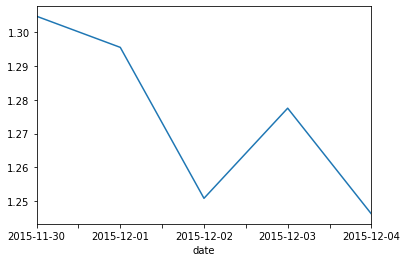

In [11]:
date_ratio=merged_table[merged_table.test==0].groupby(['date']).conversion.mean()/merged_table[
    merged_table.test==1].groupby(['date']).conversion.mean()
axis=date_ratio.plot.line()

In [48]:
country_count_control=merged_table[merged_table.test==0].groupby(['country']).test.count()
#no Spanish user in the test group
country_count_control.drop(labels=['Spain'],inplace=True)
country_count_test=merged_table[merged_table.test==1].groupby(['country']).test.count()

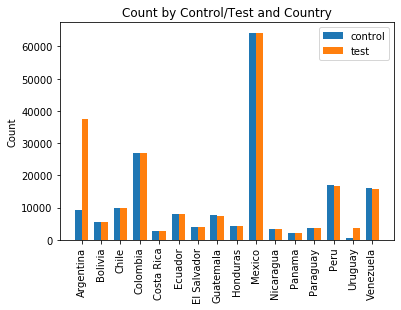

In [47]:
labels = country_count_control.index.to_list()
control_means = list(country_count_control.values)
test_means = list(country_count_test.values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, control_means, width, label='control')
rects2 = ax.bar(x + width/2, test_means, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count by Control/Test and Country')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90)
ax.legend()

In [43]:
country_rate_control=merged_table[merged_table.test==0].groupby(['country']).conversion.mean()
country_rate_control.drop(labels=['Spain'],inplace=True)
country_rate_test=merged_table[merged_table.test==1].groupby(['country']).conversion.mean()

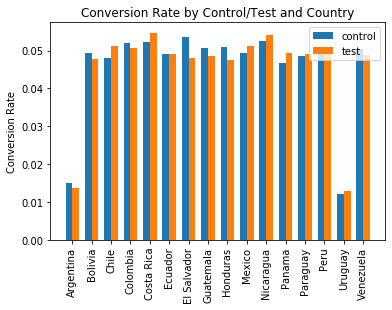

In [44]:
#sns.barplot(x='country',y='conversion',hue='test',data=data,ax=ax)
labels = country_rate_control.index.to_list()
control_means = list(country_rate_control.values)
test_means = list(country_rate_test.values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, control_means, width, label='control')
rects2 = ax.bar(x + width/2, test_means, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Conversion Rate')
ax.set_title('Conversion Rate by Control/Test and Country')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90)
ax.legend()

From the visualizations above, for some countries the test group conversion rate increases, while for others the conversion rate decreases. For Argentina and Uruguary, the user count in the test group is much larger than the user count in the control group. The abnormal result is likely caused by the country selection bias.

The next step is to re-run the statistical test on the whole control/test sample and also run the test on individual countries:

In [7]:
control=merged_table[merged_table.test==0]
test=merged_table[merged_table.test==1]

In [8]:
control_size=len(control)
test_size=len(test)
control_converted=len(control[control.conversion==1])
test_converted=len(test[test.conversion==1])

In [16]:
p_pool= (control_converted+test_converted)/(control_size+test_size)

0.049559804534223074

In [21]:
se_pool=np.sqrt(p_pool*(1-p_pool)*(1/control_size+1/test_size))
print(se_pool)
d=test_converted/test_size-control_converted/control_size
print(d)

0.0006457339274691581
-0.011744410185782393


In [23]:
d<-se_pool*1.96

True

Reject null hypothesis at 95% confidence level. The old version with just one translation performs better in terms of the conversion rate for the whole sample.

In [58]:
countries=[name for name in merged_table['country'].unique() if name is not np.nan]

for country in countries:
    control_val=merged_table[(merged_table['country']==country)&(merged_table['test']==0)]['conversion'].values
    test_val=merged_table[(merged_table['country']==country)&(merged_table['test']==1)]['conversion'].values
    control_mean=control_val.mean()
    test_mean=test_val.mean()
    p_val=ttest_ind(test_val,control_val,equal_var=False).pvalue
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country,test_mean,control_mean,p_val))

/Users/ruoqigao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


Spain                       nan         0.07972        nan
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849   0.883697
Panama                  0.04937         0.04680   0.7053

On individual country level, the test results are not significant for all countries.

Ideally, the distribution of users in the control and test set should be identical. We use decision tree to test if the randomization worked.

In [62]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_25"; Java(TM) SE Runtime Environment (build 1.8.0_25-b17); Java HotSpot(TM) 64-Bit Server VM (build 25.25-b02, mixed mode)
  Starting server from /Users/ruoqigao/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2m/6xtxljpj4xnd96l3dpxkgv0c0000gn/T/tmppww_vvru
  JVM stdout: /var/folders/2m/6xtxljpj4xnd96l3dpxkgv0c0000gn/T/tmppww_vvru/h2o_ruoqigao_started_from_python.out
  JVM stderr: /var/folders/2m/6xtxljpj4xnd96l3dpxkgv0c0000gn/T/tmppww_vvru/h2o_ruoqigao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_ruoqigao_7s67p1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [67]:
h2o_df=H2OFrame(merged_table)
h2o_df['test']=h2o_df['test'].asfactor()
h2o_df['ads_channel']=h2o_df['ads_channel'].asfactor()
#h2o_df.summary()
features=['user_id','date','source','device','browser_language','ads_channel','browser','sex','age','country']
target='test'
model=H2OGradientBoostingEstimator(ntrees=2,max_depth=2)
model.train(x=features,y=target,training_frame=h2o_df)
print(model.varimp(True))

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
           variable  relative_importance  scaled_importance  percentage
0           country         31721.337891                1.0         1.0
1           user_id             0.000000                0.0         0.0
2              date             0.000000                0.0         0.0
3            source             0.000000                0.0         0.0
4            device             0.000000                0.0         0.0
5  browser_language             0.000000                0.0         0.0
6       ads_channel             0.000000                0.0         0.0
7           browser             0.000000                0.0         0.0
8               sex             0.000000                0.0         0.0
9               age             0.000000                0.0         0.0


The Gradient Boosting Estimator's result shows that country is the only factor that determines if a user is in the test group or in the control group. It means that the country assignment is not random. 